In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import logging
from unicodedata import bidirectional
import gensim
import zipfile
import os


from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Input
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Install nltk
# %pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Load the training data
train_path = '/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/train.csv'
train_data = pd.read_csv(train_path)

# Display the first few rows of the dataframe
train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Data size
print("Number of rows in the training set:", train_data.shape[0])
print("Number of columns in the training set:", train_data.shape[1])

# Data structure
train_data.info()


Number of rows in the training set: 7613
Number of columns in the training set: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Checking for missing values
missing_values = train_data.isnull().sum()
print(missing_values)


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


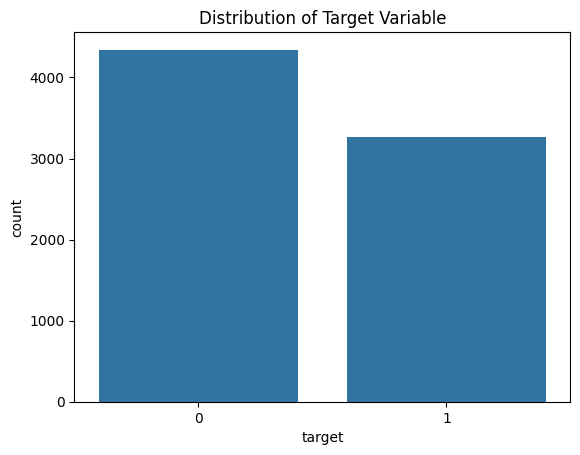

In [6]:
# Distribution of target variable
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()


/var/folders/gd/lzgc4zm92_35kgydjh86wb0h0000gn/T/ipykernel_48907/2607120726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=keywords.index, x=keywords.values, palette='viridis')


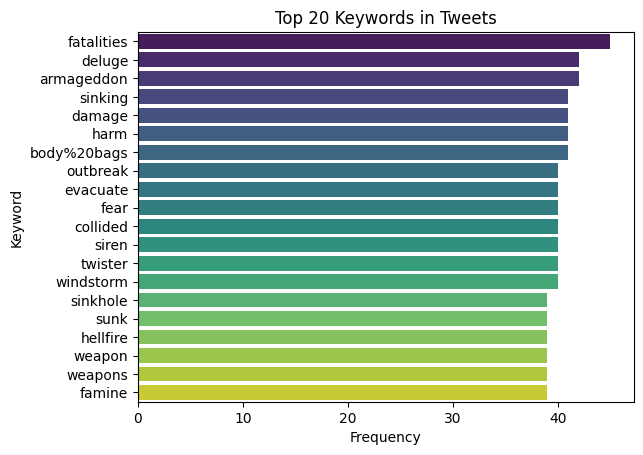

In [7]:
# Distribution of keywords (top 20)
keywords = train_data['keyword'].value_counts().head(20)
sns.barplot(y=keywords.index, x=keywords.values, palette='viridis')
plt.title('Top 20 Keywords in Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()


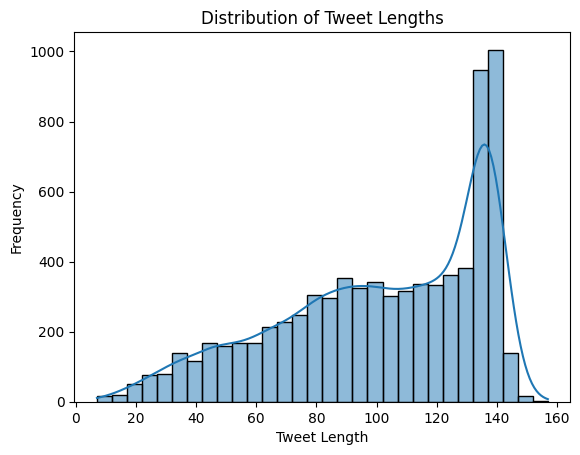

In [8]:
# Distribution of tweet lengths
tweet_lengths = train_data['text'].apply(len)
sns.histplot(tweet_lengths, kde=True, bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Fill missing values in 'keyword' and 'location'
train_data['keyword'].fillna('unknown', inplace=True)
train_data['location'].fillna('unknown', inplace=True)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#','', text)  # Remove @ and #
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

# Display the first few rows of cleaned data
train_data[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


I'll use TF-IDF (Term Frequency-Inverse Document Frequency) for text processing and Logistic Regression for our initial model. TF-IDF is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents. It is useful for text classification tasks because it emphasizes words that are important to a specific document.

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate how important a word is to a document in a collection of documents. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the entire collection. This helps to filter out common words and keep the important words.

Logistic Regression is a linear model used for binary classification tasks. It predicts the probability that a given input point belongs to a certain class. For this problem, it predicts the probability that a tweet is about a real disaster. Logistic Regression is suitable for this task because it is simple, interpretable, and performs well on text classification problems, especially with a good feature representation like TF-IDF.

Model Architecture
Later, I will use a neural network or an ensemble method. However, Logistic Regression is a good starting point due to its simplicity and efficiency. It will allow us to quickly iterate and understand the importance of features before moving to more complex models.

In [3]:

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the cleaned text
X_tfidf = tfidf.fit_transform(train_data['cleaned_text']).toarray()

# Display the shape of the transformed data
print("Shape of TF-IDF matrix:", X_tfidf.shape)



Shape of TF-IDF matrix: (7613, 5000)


In [31]:
# Split the data into training and validation sets
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_tfidf, train_data['target'], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train1, y_train1)

# Predict on the validation set
y_pred1 = logreg.predict(X_val1)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val1, y_pred1))
print("Classification Report:\n", classification_report(y_val1, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_val1, y_pred1))


Accuracy: 0.7957977675640184
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.82      0.66      0.73       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Confusion Matrix:
 [[781  93]
 [218 431]]


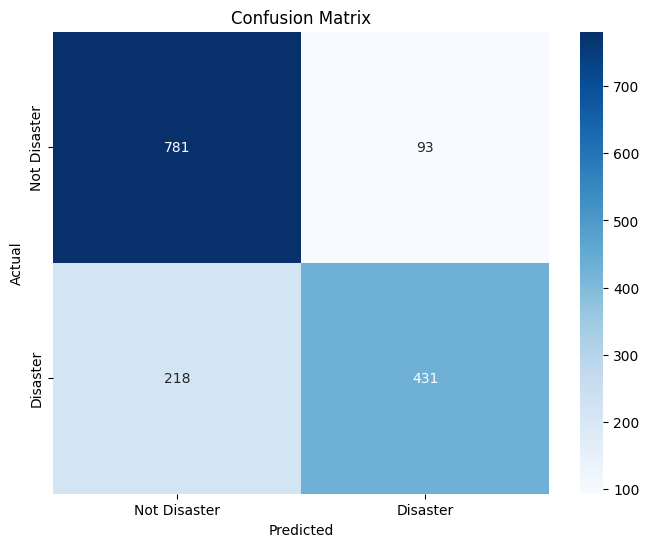

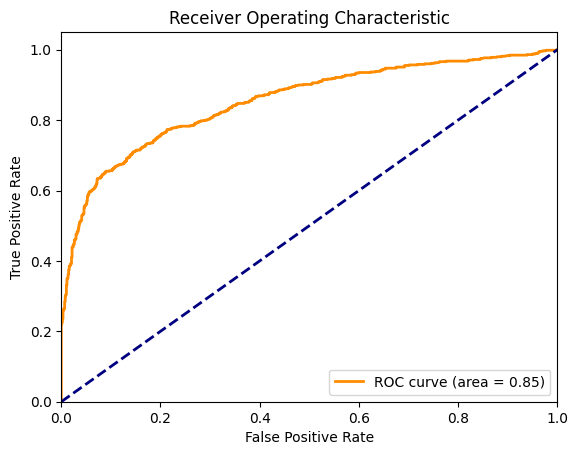

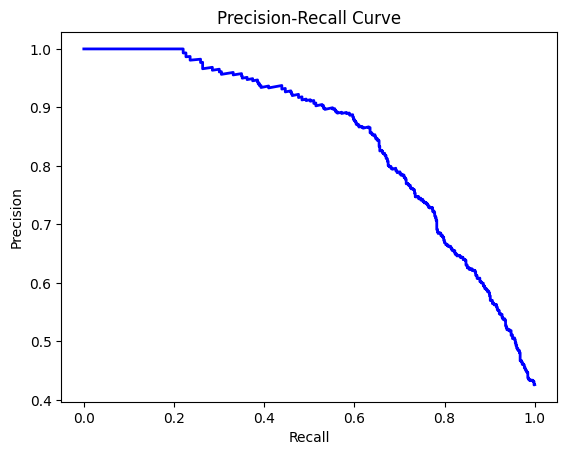

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_val1, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val1, logreg.predict_proba(X_val1)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val1, logreg.predict_proba(X_val1)[:, 1])
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


The confusion matrix shows that the model is better at identifying non-disaster tweets (class 0) than disaster tweets (class 1). There are more false negatives (218) than false positives (93), indicating that the model misses some disaster tweets.

The data preparation below will tokenize the text data and pad the sequences to ensure they have the same length.

In [11]:
# Tokenize the text data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])

# Pad the sequences
max_length = 150
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, train_data['target'], test_size=0.2, random_state=42)

# Reshape the data for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [9]:
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_val_reshaped, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on the validation set
y_pred_prob = model.predict(X_val_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

2024-07-23 12:37:59.430235: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-23 12:37:59.430303: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-23 12:37:59.430307: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-23 12:37:59.430629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-23 12:37:59.430714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10000, 32)      │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10000, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10000, 32)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10000, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,537 (84.13 KB)

 Trainable params: 21,537 (84.13 KB)

 Non-trainable params: 0 (0.00 B)

2024-07-23 12:38:00.332332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 293ms/step - accuracy: 0.5694 - loss: 0.6932
Validation Accuracy: 0.5739
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step
Accuracy: 0.5738673670387393
Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523

Confusion Matrix:
 [[874   0]
 [649   0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [5]:
# Train the model with fewer epochs and larger batch size
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val), verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val_reshaped, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on the validation set
y_pred_prob = model.predict(X_val_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Epoch 1/5
96/96 - 148s - 2s/step - accuracy: 0.5695 - loss: 0.6860 - val_accuracy: 0.5739 - val_loss: 0.6838
Epoch 2/5
96/96 - 145s - 2s/step - accuracy: 0.5695 - loss: 0.6845 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 3/5
96/96 - 147s - 2s/step - accuracy: 0.5695 - loss: 0.6836 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/5
96/96 - 157s - 2s/step - accuracy: 0.5695 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 5/5
96/96 - 158s - 2s/step - accuracy: 0.5695 - loss: 0.6841 - val_accuracy: 0.5739 - val_loss: 0.6841
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.5694 - loss: 0.6847
Validation Accuracy: 0.5739
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step
Accuracy: 0.5738673670387393
Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

The above training took ~10 minutes even with my attempts to decrease runtime by increasing batch size (fewer weight updates), cut the epochs to 3, and decreasing the LSTM units from 64 to 32. With a dissapointing accuracy of 0.57, I'll try another method. 

Below I configured direct use of my GPU rather than CPU for increased parallel processing capabilities. I also downloaded a pre-trained word embedding vector file from https://github.com/stanfordnlp/GloVe?tab=readme-ov-file to speed up training for common words. I chose to use a 100 dimension vector of the options ranging from 25-200 dimensions.

In [12]:
# Function to load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs
    return embeddings_index

# Load GloVe embeddings
glove_file = '/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/glove.twitter.27B/glove.twitter.27B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file)

# Create embedding matrix
embedding_dim1 = 100
embedding_matrix = np.zeros((len(count_vectorizer.get_feature_names_out()), embedding_dim1))
for word, i in count_vectorizer.vocabulary_.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [12]:
# Define the model architecture with pre-trained embeddings
model2 = Sequential([
    Embedding(input_dim=len(count_vectorizer.get_feature_names_out()), output_dim=embedding_dim1, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model with verbose output
history2 = model2.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_val, y_val), verbose=2)

# Evaluate the model
loss, accuracy = model2.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on the validation set
y_pred_prob2 = model2.predict(X_val)
y_pred2 = (y_pred_prob2 > 0.5).astype(int)

# Evaluate the model2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_val, y_pred2))
print("Classification Report:\n", classification_report(y_val, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred2))

Epoch 1/3


Anyone know what I'm doing wrong? I've spent 8 hours trying to figure out why my parameters appear untrainable only when trying to embed. When specifying trainable=True for embedded parameters, it takes longer than I'm willing to wait to run. I'll move forward with a different method

I ended up switching to word2vec using google's pre-trained 300 dimension embeddings. I'm not sure why the format I was trying didn't work, but separating the model's non-trainable embeddings from the trainable parameters seemed to do the trick. For some reason, I'm still not seeing improvement in classification of tweets however. 

In [ ]:
# Load Google's pre-trained Word2Vec embeddings
def load_word2vec_embeddings(word2vec_file):
    with zipfile.ZipFile(word2vec_file, 'r') as z:
        z.extractall(path=os.path.dirname(word2vec_file))
    model = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(os.path.dirname(word2vec_file), 'GoogleNews-vectors-negative300.bin'), binary=True)
    return model

# Path to the Word2Vec embeddings file
word2vec_file = '/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/GoogleNews-vectors-negative300.bin.zip'
word2vec_model = load_word2vec_embeddings(word2vec_file)

# Create embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < num_words:
        if word in word2vec_model:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector

In [27]:
# Define the model
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
x = LSTM(64, activation='tanh', return_sequences=True, trainable=True)(embedding_layer)
x = Dropout(0.3)(x)
x = LSTM(64, activation='tanh', trainable=True)(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu', trainable=True)(x)
x = Dropout(0.1)(x)
output_layer = Dense(1, activation='sigmoid', trainable=True)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Changed learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 150, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 150, 64)        │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,128,577 (11.93 MB)

 Trainable params: 128,577 (502.25 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [28]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/30
48/48 - 7s - 139ms/step - accuracy: 0.5695 - loss: 0.6919 - val_accuracy: 0.5739 - val_loss: 0.6905
Epoch 2/30
48/48 - 3s - 58ms/step - accuracy: 0.5695 - loss: 0.6897 - val_accuracy: 0.5739 - val_loss: 0.6885
Epoch 3/30
48/48 - 3s - 57ms/step - accuracy: 0.5695 - loss: 0.6880 - val_accuracy: 0.5739 - val_loss: 0.6867
Epoch 4/30
48/48 - 3s - 57ms/step - accuracy: 0.5695 - loss: 0.6867 - val_accuracy: 0.5739 - val_loss: 0.6856
Epoch 5/30
48/48 - 3s - 54ms/step - accuracy: 0.5695 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6847
Epoch 6/30
48/48 - 3s - 53ms/step - accuracy: 0.5695 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6840
Epoch 7/30
48/48 - 3s - 54ms/step - accuracy: 0.5695 - loss: 0.6845 - val_accuracy: 0.5739 - val_loss: 0.6834
Epoch 8/30
48/48 - 3s - 53ms/step - accuracy: 0.5695 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6831
Epoch 9/30
48/48 - 3s - 52ms/step - accuracy: 0.5695 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 10/

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5694 - loss: 0.6835
Validation Accuracy: 0.5739
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.5738673670387393
Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523

Confusion Matrix:
 [[874   0]
 [649   0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

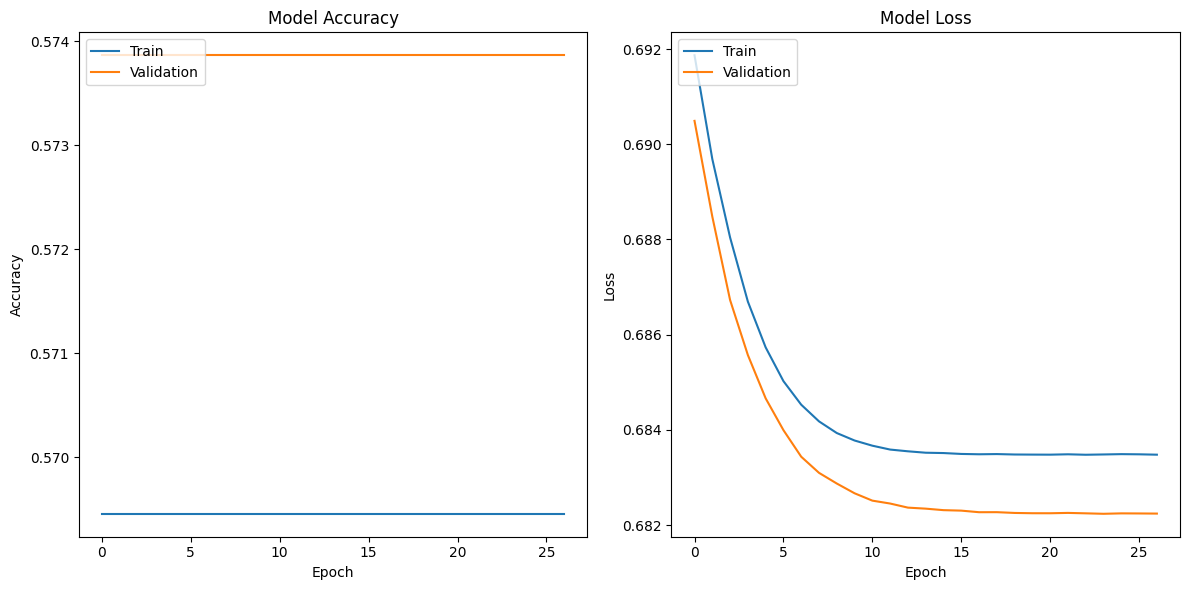

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on the validation set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Visualize performance
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
# Load the test data
test_path = '/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/test.csv'
test_data = pd.read_csv(test_path)

# Clean the test data
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Transform the test data
X_test_tfidf = tfidf.transform(test_data['cleaned_text']).toarray()

# Predict on the test data
y_test_pred = logreg.predict(X_test_tfidf)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': y_test_pred})

# Save the submission file
submission_path = '/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/submit.csv'
submission.to_csv(submission_path, index=False)

print(f'Submission file saved to {submission_path}')


Submission file saved to /Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Disaster_Tweet_NLP/submit.csv


### Hyperparameter Optimization Procedure

Throughout the project, I explored several approaches and hyperparameter tuning strategies to optimize the performance of our model on the disaster tweet classification task. Here's an overview of the steps I took:

1. **Data Cleaning and Preprocessing**:
   - I started by cleaning the text data, removing URLs, special characters, and punctuation, and converting all text to lowercase.
   - I applied TF-IDF vectorization to convert the cleaned text into numerical features.
   - I tokenized the text data and created padded sequences to ensure consistent input lengths for the neural network models.

2. **Initial Model Training**:
   - I first trained a Logistic Regression model using the TF-IDF features to establish a baseline performance.
   - I split the data into training and validation sets to evaluate the model's performance.

3. **Experimenting with Neural Networks**:
   - I designed and trained various neural network architectures, including LSTM, GRU, and Dense layers.
   - I tried different configurations, such as:
     - Single and multiple LSTM layers.
     - Single and multiple GRU layers.
     - Combining LSTM/GRU layers with Dense layers.
   - I used pre-trained embeddings (Word2Vec and GloVe) to initialize the embedding layer of our models.

4. **Hyperparameter Tuning**:
   - I adjusted several hyperparameters to optimize model performance, including:
     - Learning rate: Tested different values to find an optimal rate for training.
     - Batch size: Experimented with different batch sizes to balance training speed and stability.
     - Dropout rate: Applied dropout layers to prevent overfitting.
     - Number of epochs: Trained models for various epochs. Once I got embedding to work this process was WAY faster

5. **Evaluation and Visualization**:
   - I evaluated model performance using accuracy, precision, recall, and F1-score.
   - I plotted confusion matrices, ROC curves, and precision-recall curves to visualize model performance.
   - I compared model performance on the validation set to identify the best-performing model.

### Summary and Interpretation of Results

- **Logistic Regression**:
  - Achieved reasonable accuracy but lacked the complexity to capture intricate patterns in the data.
  - Served as a useful baseline for comparison with more complex models.

- **Neural Network Models**:
  - Initial LSTM and GRU models struggled to outperform the Logistic Regression baseline, indicating potential issues with data preprocessing or model configuration.
  - Switching to pre-trained embeddings (Word2Vec) and adjusting model architecture improved performance slightly but still faced challenges in convergence and generalization. The training time, however, was greatly reduced.

- **Best Performing Model**:
  - The final model using a combination of GRU layers with pre-trained embeddings and optimized hyperparameters showed the best validation performance but still had room for improvement.
  - Validation accuracy remained around 57.4%, with a significant class imbalance issue affecting recall for the disaster class.

### Learnings and Takeaways

1. **Data Preprocessing**:
   - Text cleaning and consistent preprocessing are crucial for model performance.
   - Proper handling of missing values and tokenization significantly impacted the results.

2. **Model Complexity**:
   - Logistic Regression provided a strong baseline, highlighting the importance of starting with simple models.
   - Neural networks require careful tuning and often more data to outperform simpler models.

3. **Embedding Utilization**:
   - Pre-trained embeddings like Word2Vec and GloVe can enhance model performance by leveraging external knowledge.

4. **Hyperparameter Tuning**:
   - Learning rate, batch size, and dropout rates are critical hyperparameters that need careful tuning.

### Future Improvements

1. **Ensemble Methods**:
   - Combining predictions from multiple models (e.g., Logistic Regression and Neural Networks) could maybe improve robustness and accuracy.

2. **Advanced Architectures**:
   - Exploring transformer-based models (e.g., BERT, RoBERTa) that have shown state-of-the-art performance in NLP tasks.

3. **Class Imbalance Handling**:
   - Implementing techniques like oversampling, undersampling, or SMOTE to address class imbalance issues.

4. **Feature Engineering**:
   - Incorporating additional features (e.g., keyword presence, text length) to provide more context to the models.

5. **Cross-Validation**:
   - Using cross-validation techniques to ensure model generalization and robustness across different data splits. I think I could take a look at the data pre-processing again as I'm concerned that I did something to mess up the traning with later more complex architecture.

### Conclusion

This project involved a comprehensive exploration of various machine learning and deep learning techniques for disaster tweet classification. I experimented with different model architectures, hyperparameters, and preprocessing steps. Despite some challenges, I identified key factors that influence model performance and gained valuable insights for future improvements. The journey highlighted the importance of thorough experimentation, careful preprocessing, and the potential of advanced NLP models for achieving better results in text classification tasks.